# Modeling Diffusion

## Imports

In [1]:
import numpy as np
import scipy.linalg as la
from scipy.integrate import quad
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')
from tqdm import tqdm
import pandas as pd
from typing import Callable

## Constant Diffusion Coefficient

### Background

First I will calculate a numerical solution. I decided to go with a simple implicit finite difference solution method, the Crank-Nicolson method. I figured this was a good choice as the diffusion equation is stiff so implicit methods can reduce the error from large timesteps. I'll start with the homogeneuos equation, then add in the reaction term.

$$
\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2} - kC
$$

The Crank-Nicolson method discretizes the diffusion equation into a finite differences in space and time. The $t$ and $x$ discretizations are defined as follows:

$$
\begin{align}
x_i = x_0 + i \Delta x, \qquad i = 0,1,\dots,N_x
\\[1em]
t_n = t_0 + n \Delta t, \qquad n = 0,1,\dots, N_t
\end{align}
$$

In particular, it uses a trapezoidal approximation to integrating from $t_n$ to $t_{n+1}$, which ends up looking like taking the average of $\frac{\partial^2 C}{\partial x^2}$ between $t_n$ and $t_{n+1}$. This results in a tridiagonal system of equations over the whole discretized spatial coordinate.

$$
\begin{align}
\frac{\partial C}{\partial t} &= D \frac{\partial^2 C}{\partial x^2}
\\[1em]
\frac{\Delta_+ C}{\Delta t} &= D \cdot \text{Avg}_{[n,n+1]} \left(\frac{\Delta^2 C}{\Delta x^2}\right)
\\[1em]
\frac{C_i^{n+1}-C_i^n}{\Delta t} &= D\frac{1}{2}\left(\frac{C_{i-1}^n-2C_i^n+C_{i+1}^n}{\Delta x^2}+\frac{C_{i-1}^{n+1}-2C_i^{n+1}+C_{i+1}^{n+1}}{\Delta x^2}\right)
\end{align}
$$

With some rearranging, this gives a general formula for how to get $C_i^{n+1}$ for all positions $x_i$, given knowledge of $C_i^n$. For Dirichlet boundaries, the concentration is just 0 at $x = 0$ and $x=L$, i.e., $x_0$ and $x_{N_x}$. They won't effect the rest of the substrate and we can ignore them as long as $C^n[0]=C^n[-1]=0$ is enforced for all n (more on this later).

$$
A \bold{C}^{n+1} = B \bold{C}^n

\\[1em]

r \equiv \frac{D \Delta t}{2 \Delta x^2}

\\[1em]

A = \begin{bmatrix}
    (1+2r) & -r & & & & \\
    -r & (1+2r) & -r & & & \\
      & -r & (1+2r) & -r & & \\
      & & \ddots & \ddots & \ddots & \\
      & & & -r & (1+2r) & -r \\
      & & & & -r & (1+2r)
\end{bmatrix}

\\[1em]

B = \begin{bmatrix}
    (1-2r) & r & & & & \\
    r & (1-2r) & r & & & \\
      & r & (1-2r) & r & & \\
      & & \ddots & \ddots & \ddots & \\
      & & & r & (1-2r) & r \\
      & & & & r & (1-2r)
\end{bmatrix}
$$


From here, it's pretty straighforward (at least numerically) to add in the $kC$ reaction term: it just adjusts the concentration by $-\Delta t k C_i$ each timestep, at each point $x_i$. This is called an implicit/explicit (IMEX) method, because the spatial/laplacian term is determined implicitly with Crank-Nicolson while the reaction term is determined with explicit Euler.

$$
A \bold{C}^{n+1} = B \bold{C}^n - \Delta t k \bold{C}^n
$$

### Neumann Boundary Conditions

A more physical boundary is to have $\frac{\partial C}{\partial x} = 0$ at $x_0$ and $x_{N_x}$, i.e, there is no flux of concentration into or out of the boundary.

Thus, using central differences at $C_0$ and $C_{N_x}$:

$$
\begin{align}
\frac{C_1-C_{-1}}{2 \Delta x} = 0 \rightarrow C_1 = C_{-1} \qquad &\text{and} \qquad \frac{C_{N_x+1}-C_{N_x-1}}{2 \Delta x} = 0 \rightarrow C_{N_x-1} = C_{N_x+1}
\\[1em]
\frac{\Delta^2 C_0}{\Delta x^2} = \frac{C_{-1}-2C_0+C_{1}}{\Delta x^2} = \frac{2C_{1}-2C_0}{\Delta x^2} \qquad &\text{and} 
\qquad \frac{\Delta^2 C_{N_x}}{\Delta x^2} = \frac{C_{N_x-1}-2C_{N_x}+C_{N_x+1}}{\Delta x^2} = \frac{2C_{N_x-1}-2C_{N_x}}{\Delta x^2}
\end{align}
$$

The result is simply that the off-diagonal coefficients are doubled in the matrices A and B at the boundaries.

$$
A = \begin{bmatrix}
    (1+2r) & \mathbf{-2r} & & & & \\
    -r & (1+2r) & -r & & & \\
      & -r & (1+2r) & -r & & \\
      & & \ddots & \ddots & \ddots & \\
      & & & -r & (1+2r) & -r \\
      & & & & \mathbf{-2r} & (1+2r)
\end{bmatrix}

\\[1em]

B = \begin{bmatrix}
    (1-2r) & \mathbf{2r} & & & & \\
    r & (1-2r) & r & & & \\
      & r & (1-2r) & r & & \\
      & & \ddots & \ddots & \ddots & \\
      & & & r & (1-2r) & r \\
      & & & & \mathbf{2r} & (1-2r)
\end{bmatrix}
$$

Also, we can now check that the solution actually makes sense by accounting for conservation of the solute.

### Limits on Stability


An IMEX solution does have the downside that with the addition of an explicit term on the right hand side, the solution is no longer unconditionally stable. Instead, the size of the timesteps must be deterined to fit the stability condition:

$$
\Delta t \lesssim \frac{2}{k}
$$

--------------

Additionally, while Crank-Nicolson is unconditionally stable, it still isn't L-stable and will cause spurious oscillations from very stiff terms/large eigenvalues. This can be minimized by proper selection of $dx$ and $dt$ sizes.


### Analytic Solution

Here is an analytic solution for comparison:

$$

C(x,t) = \begin{cases}

% Neumann
\sum_{m=0}^\infty a_m \cos(\frac{m\pi x}{L}) e^{-(D(m \pi / L)^2 + k)t}, 
& \text{Neumann}

\\[1em]

% Dirichlet
\sum_{m=0}^\infty b_m \sin(\frac{m\pi x}{L}) e^{-(D(m \pi / L)^2 +k)t},
& \text{Dirichlet}

\end{cases}

$$



$$

\begin{align}

a_m &= \frac{2}{L} \int_0^L C_0(x) \cos(\frac{m \pi x}{L}) dx

\\[1em]

b_m &= \frac{2 C_0}{m \pi} (1-(-1)^m)

\end{align}
$$


### Implementation

In [2]:
def imex(C0: Callable, D, L, k, tf, bounds, Nx=500, Nt=500, x_scale=None):
    '''
    Uses CN propagation to find concentration profile over time. 
    Includes explicit reaction term.
    bounds == 'Neumann': Uses boundary condition of 0 flux at boundaries.
    bounds == 'Dirichlet': Uses boundary condition C(0,0)=C(0,L)=0.
    dx, dt unconstrained by stiffness parameter.

    C0: function that represents the concentration profile at t=0.
    D: diffusion coefficient
    L: length of rod
    tf: final time
    bounds: boundary conditions
    Nx: Number of space steps. Including the 0th point, returns a matrix with dimention Nx+1.
    Nt: Number of time steps. Including the 0th point, returns a matrix with dimention Nt+1.
    x_scale: Optional rescale of x grid points.
    '''

    dt = tf/Nt # t_0 = 0, t_1 = dt, t_2 = 2*dt, ...,t_n = n*dt, t_Nt = Nt*dt = tf
    dx = L/Nx # x_0 = 0, x_1 = dx, x_2 = 2*dx, ..., x_i = i*dx, x_Nx = Nx*dx = L
    r = (D*dt)/(2*dx**2)
    
    if k != 0 and dt > 2/k:
        tqdm.write(f"dt={dt:.5f} outside of stability conditions! (Nt={Nt}, k={k})")
        
    A_bands = np.zeros((3,Nx+1)) # Diagonal matrix; diagonal elements from i=0 to i=Nx
    A_bands[0,1:] = -r
    A_bands[1,:] = 1+2*r
    A_bands[2,:-1] = -r

    B_bands = np.zeros((3,Nx+1))
    B_bands[0,1:] = r
    B_bands[1,:] = 1-2*r
    B_bands[2,:-1] = r
    B = np.diag(B_bands[1,:]) + np.diag(B_bands[0,1:], k=+1)+np.diag(B_bands[2,:-1], k=-1)
    # B = np.diag((1-2*r) * np.ones(Nx+1)) + np.diag(r*np.ones(Nx), k=+1)+np.diag(r*np.ones(Nx), k=-1)

    if bounds == 'Neumann':
        # Adjust for Neumann conditions:
        A_bands[0,1] = -2*r
        A_bands[2,-2] = -2*r
        B[0,1] = 2*r
        B[-1,-2] = 2*r
    elif bounds == 'Dirichlet': # Exclude endpoints for dirichlet
        # Set first row as identity
        A_bands[0,1] = 0
        A_bands[1,0] = 1
        A_bands[2,0] = 0
        # Set last row as identity
        A_bands[0,-1] = 0
        A_bands[1,-1] = 1
        A_bands[2,-2] = 0

    C = np.empty((Nt+1, Nx+1)) # (n,i) from (0,0) to (Nt, Nx)
    xgrid = np.linspace(0, L, Nx+1)
    C[0,:] = C0(xgrid)

    for n in range(Nt):
        RHS = B@C[n] - dt*k*C[n]
        if bounds == 'Dirichlet':
            # Enforce Dirichlet Boundary
            RHS[0]=0
            RHS[-1]=0
        C[n+1,:]=la.solve_banded((1,1), A_bands, RHS) # (1,1) denotes A has 1 diagonal row above main diag, 1 below.
         
            
    # Rescale output x spacing (old method)
    if x_scale is not None:
        C_rescaled = np.empty((Nt+1, x_scale))
        x_old = xgrid
        x_new = np.linspace(0, L, x_scale)

        for n in range(Nt+1):
            C_rescaled[n] = np.interp(x_new, x_old, C[n])
        
        C = C_rescaled

    return C

def analytic(C0: Callable, D, L, k, tf, bounds, Nx=500, M=100):
    '''
    An analytic solution to compare results with.
    bounds == 'Neumann': Uses Neumann conditions at boundaries. Works for any initial concentration profile which can be expressed as a Fourier cosine series.
    bounds == 'Dirichlet': Uses dirichlet conditions. **Only works with constant initial concentrations.**
    
    Nx: Number of space steps. Including the 0th point, returns a matrix with dimention Nx+1.
    M: The number of fourier terms computed in the infinite sum.
    '''

    if bounds == 'Neumann':
        x = np.linspace(0, L, Nx+1)

        a0 = (1/L)*quad(C0, 0, L)[0] # quad returns (answer, err)
        C = np.zeros_like(x) + a0*np.exp(-k * tf)
        for m in range(1, M+1):
            f = lambda x: C0(x)*np.cos((m*np.pi*x) / L)
            am= (2/L)*quad(f, 0, L)[0] 

            C += am * np.cos((m*np.pi*x) / L) * np.exp( -(D*((m*np.pi)/L)**2 + k) * tf )
        return C
    
    if bounds == 'Dirichlet':
        C_0 = C0(0)
        x = np.linspace(0, L, Nx+1)
        C = np.zeros_like(x)
        for m in range(1, M+1):
            bm = ((2.0*C_0)/(m*np.pi))*(1 - (-1)**m)
            C += bm * np.sin((m*np.pi*x)/L) * np.exp(-(k + D*((m*np.pi)/L)**2)*tf)
        return C

### Plotting Numerical vs. Analytic Solution

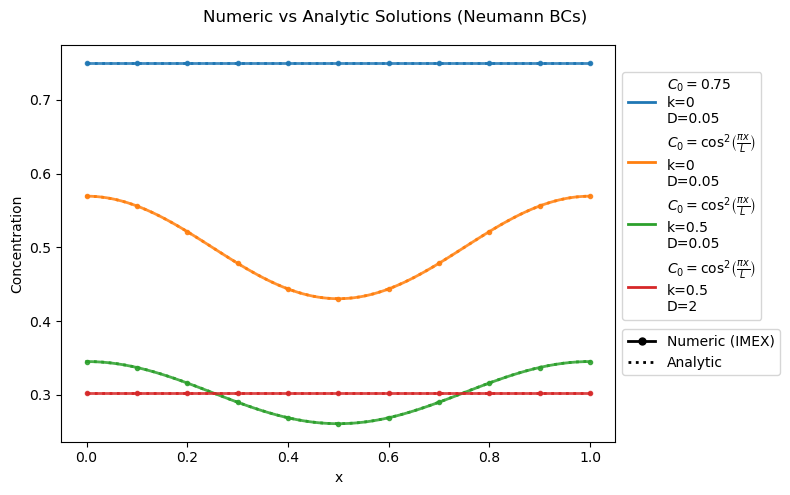

In [ ]:
# Plotting some numeric vs analytic solutions (Source: ChatGPT)
analytic = analytic
numeric  = imex

params = {
    "D": 0.05,
    "L": 1,
    "k": 0,
    "tf": 1,
    "bounds": 'Neumann'
}

L  = params["L"]
Nx = 100
x  = np.linspace(0, L, Nx+1)

cases = [
    {
        "C0": lambda x: 0.75,
        "k": 0,
        "D": 0.05,
        "label": r"$C_0 = 0.75$" + '\n' + "k=0" + '\n' + 'D=0.05',
        "color": "C0"
    },
    {
        "C0": lambda x: np.cos(np.pi*x/L)**2,
        "k": 0,
        "D": 0.05,
        "label": r"$C_0 = \cos^2\!\left(\frac{\pi x}{L}\right)$" + '\n' + "k=0" + '\n' + 'D=0.05',
        "color": "C1"
    },
    {
        "C0": lambda x: np.cos(np.pi*x/L)**2,
        "k": 0.5,
        "D": 0.05,
        "label": r"$C_0 = \cos^2\!\left(\frac{\pi x}{L}\right)$" + '\n' + "k=0.5" + '\n' + 'D=0.05',
        "color": "C2"
    },
    {
        "C0": lambda x: np.cos(np.pi*x/L)**2,
        "k": 0.5,
        "D": 2,
        "label": r"$C_0 = \cos^2\!\left(\frac{\pi x}{L}\right)$" + '\n' + "k=0.5" + '\n' + 'D=2',
        "color": "C3"
    }
]

plt.figure(figsize=(8,5))

for case in cases:
    params["C0"] = case["C0"]
    params["k"]  = case["k"]
    params["D"]  = case["D"]

    C_an  = analytic(**params, Nx=Nx)
    C_num = numeric(**params, Nx=Nx)[-1]

    # Numeric solution: solid line + markers
    plt.plot(
        x, C_num,
        color=case["color"],
        linestyle="-",
        linewidth=2,
        marker="o",
        markersize=3,
        markevery=10,
        alpha=0.85
    )

    # Analytic solution: dotted line
    plt.plot(
        x, C_an,
        color=case["color"],
        linestyle=":",
        linewidth=2
    )

plt.xlabel("x")
plt.ylabel("Concentration")
plt.suptitle(f"Numeric vs Analytic Solutions ({params['bounds']} BCs)")

# Legend for initial conditions (colors)
ic_handles = [
    Line2D([0], [0], color=case["color"], lw=2, label=case["label"])
    for case in cases
]
legend1 = plt.legend(handles=ic_handles, loc='upper left', bbox_to_anchor=(1, 0.95))
plt.gca().add_artist(legend1)

# Legend for method (linestyle)
method_handles = [
    Line2D([0], [0], color="black", lw=2, linestyle="-",
           marker="o", markersize=5, label="Numeric (IMEX)"),
    Line2D([0], [0], color="black", lw=2, linestyle=":",
           label="Analytic")
]
plt.legend(handles=method_handles, loc='lower left', bbox_to_anchor=(1, 0.15))

plt.tight_layout()
plt.show()


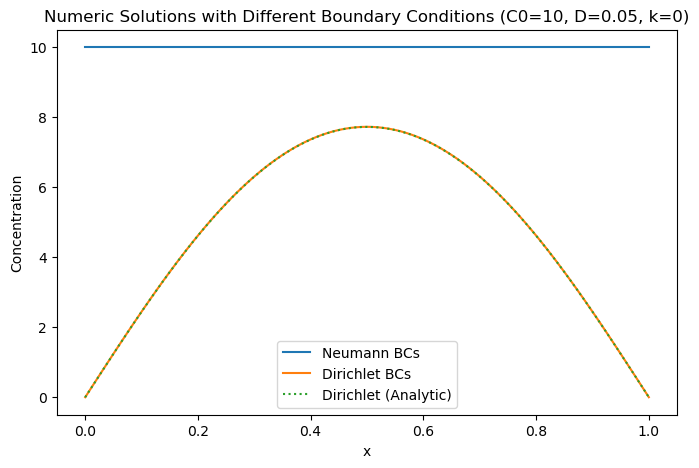

In [5]:
# plotting Neumann vs. Dirichlet Solution

params = {
    "C0": lambda x: 10,
    "D": 0.05,
    "L": 1,
    "k": 0,
    "tf": 1,
    "bounds": 'Neumann'
}
L  = params["L"]
Nx = 100
x  = np.linspace(0, L, Nx+1)

C_neumann = imex(**params, Nx=Nx)[-1]
params["bounds"] = 'Dirichlet'
C_dirichlet = imex(**params, Nx=Nx)[-1]
C_analytic = analytic(**params, Nx=Nx)

plt.figure(figsize=(8,5))
plt.plot(x, C_neumann, label="Neumann BCs")
plt.plot(x, C_dirichlet, label="Dirichlet BCs")
plt.plot(x, C_analytic, linestyle = 'dotted', label="Dirichlet (Analytic)")
plt.xlabel("x")
plt.ylabel("Concentration")
plt.title(f"Numeric Solutions with Different Boundary Conditions (C0=10, D={params['D']}, k={params['k']})")
plt.legend()

### Testing Conservation of Solute

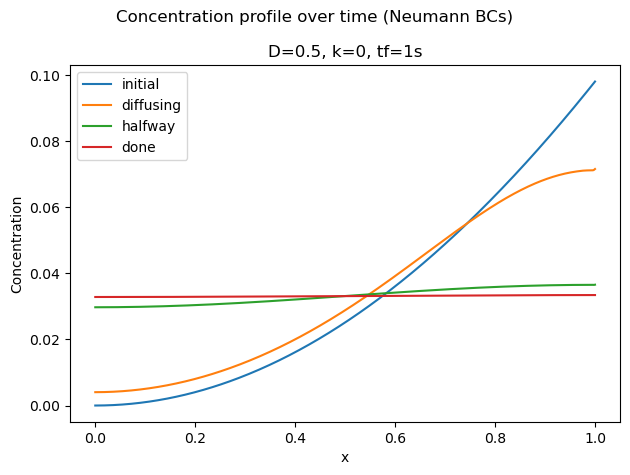

Total Solute:
t=0.00s: 0.0331
t=0.04s: 0.0331
t=0.50s: 0.0331
t=1.00s: 0.0331


In [6]:
# Testing conservation of solute
numeric = imex

params = {
    "C0": lambda x: np.sin(x/(np.pi))**2,
    "D": 0.5,
    "L": 1,
    "k": 0,
    "tf": 1,
    "bounds": 'Neumann'
}


C = numeric(**params)

L = params['L']
x = np.linspace(0, L, C.shape[1])
dt = params['tf']/C.shape[0]
dx = L/C.shape[1]

plt.plot(x, C[0], label='initial')
plt.plot(x, C[20], label = 'diffusing')
plt.plot(x, C[250], label = 'halfway')
plt.plot(x, C[-1], label='done')
plt.xlabel('x')
plt.ylabel('Concentration')
plt.suptitle(f"Concentration profile over time ({params['bounds']} BCs)")
plt.title(f"D=0.5, k=0, tf=1s")
plt.legend()
plt.tight_layout()
plt.show()

print("Total Solute:")
print(f't=0.00s: {np.sum(C[0]*dx):.4f}')
print(f't={20*dt:.2f}s: {np.sum(C[20]*dx):.4f}')
print(f't={250*dt:.2f}s: {np.sum(C[250]*dx):.4f}')
print(f't=1.00s: {np.sum(C[-1]*dx):.4f}')


In [ ]:
# Animation

numeric = imex
params = {
    "C0": lambda x: np.arccos(x)**2,
    "D": 0.5,
    "L": 1,
    "k": 0,
    "tf": 1,
    "bounds": 'Neumann'
}
L = params['L']

C = numeric(**params)
x = np.linspace(0,L,C.shape[1])
frames = C.shape[0]

fig, ax = plt.subplots()
line, = ax.plot(x,C[0]) # Creates a blank line object to animate

plt.title(f"Concentration over time: C0(x)=arccos^2(x), {params['bounds']} BCs, D={params['D']}, k={params['k']}")

def update(frame):
    line.set_ydata(C[frame,:])
    return line,

ani = FuncAnimation(fig, func=update, frames=frames, blit=True)
plt.close(fig)
ani

## Space-Dependant Diffusion Coefficient

### Background

This makes the Crank-Nicolson method slightly more complicated, since you have to average the entire spatial operator $L[C]=\frac{\partial}{\partial x}\left(D(x)\frac{\partial C}{\partial x}\right)$ between $t_n$ and $t_{n+1}$, not just $\frac{\partial^2 C}{\partial x^2}$. Using central differences still, you take the difference per $\Delta x$ between the tollowing two terms: 

- *The forward difference of C*: the difference between $C_{i+1}$ and $C_i$, $\frac{\Delta_+ C}{\Delta x}$, multiplied with the value of D between those x values, *i.e.*, $D_{\left[ i+\frac{1}{2}\right]}=\frac{1}{2} \left( D_i + D_{i+1} \right)$; *and*,

- *the backward difference in C*: the difference between $C_i$ and $C_{i-1}$, $\frac{\Delta_- C}{\Delta x}$, multiplied with the value of D between those x values, *i.e.*, $D_{\left[ i-\frac{1}{2} \right]}=\frac{1}{2} \left( D_{i-1} + D_i \right)$.

Now the equation becomes: 

$$
\begin{align}
% initial PDE
\frac{\partial C}{\partial t} &= \frac{\partial}{\partial x} \left( D(x) \frac{\partial C}{\partial x} \right)

\\[1em]
% Discretized CN PDE
\frac{\Delta_+ C}{\Delta t} &= \text{Avg}_{[n,n+1]} \left( \frac { D_{\left[ i+\frac{1}{2} \right]} \frac{\Delta_+ C}{\Delta x}
                                                                  - D_{\left[ i-\frac{1}{2} \right]} \frac{\Delta_- C}{\Delta x} }{\Delta x}\right)

\\[1em]
% Some algebra pain
\frac{C_i^{n+1}-C_i^n}{\Delta t} &= 
\frac{1}{2} \left[ 
    \frac{ D_{\left[ i+\frac{1}{2}\right]} (C_{i+1}^{n+1}-C_i^{n+1}) - D_{\left[ i-\frac{1}{2}\right]} (C_i^{n+1}-C_{i-1}^{n+1}) }{\Delta x^2} 
+   \frac{ D_{\left[ i+\frac{1}{2}\right]} (C_{i+1}^n-C_i^n) - D_{\left[ i-\frac{1}{2}\right]} (C_i^n-C_{i-1}^n) }{\Delta x^2} \right]

\end{align}
$$

Similar to before, one can define a diffusion ration $r$ to simplify the algebra. Now, there are two variable ratios, for the forward and backward differences of $D(x)$.

$$

% defining alpha diffusion ratio
r_{\left[i+\frac{1}{2} \right]} = \frac{D_{\left[ i+\frac{1}{2}\right]} \Delta t}{2 \Delta x^2} \equiv r^\alpha_i

\\[1em]
% Defining beta diffusion ratio
r_{\left[i-\frac{1}{2} \right]} = \frac{D_{\left[ i-\frac{1}{2}\right]} \Delta t}{2 \Delta x^2} \equiv r^\beta_i 

\\[1em]
% Some more algebra pain
(1 + r^\alpha_i + r^\beta_i) C_i^{n+1}
- r^\alpha_i C_{i+1}^{n+1}
- r^\beta_i C_{i-1}^{n+1}
=
(1 - r^\alpha_i - r^\beta_i) C_i^{n}
+ r^\alpha_i C_{i+1}^{n}
+ r^\beta_i C_{i-1}^{n}.


$$

In terms of A and B:

$$

\begin{align}

A_{i,i-1} &= -r^\beta_i
\\[1em]
A_{i,i}   &= 1 + r^\alpha_i + r^\beta_i
\\[1em]
A_{i,i+1} &= -r^\alpha_i
\\[1em]
B_{i,i-1} &= r^\beta_i
\\[1em]
B_{i,i}   &= 1 - r^\alpha_i - r^\beta_i
\\[1em]
B_{i,i+1} &= r^\alpha_i
\\[1em]


\end{align}

$$
$$

A = \begin{bmatrix}
    (1+r^\alpha_0 + r^\beta_0) & -r^\alpha_0 & & & & \\
    -r^\beta_1 & (1+r^\alpha_1 + r^\beta_1) & -r^\alpha_1 & & & \\
      & -r^\beta_2 & (1+r^\alpha_2 + r^\beta_2) & -r^\alpha_2 & & \\
      & & \ddots & \ddots & \ddots & \\
      & & & -r^\beta_i & (1+r^\alpha_i + r^\beta_i) & -r^\alpha_i \\
      & & & & -r^\beta_{N_x} & (1+r^\alpha_{N_x} + r^\beta_{N_x})
\end{bmatrix}

\\[1em]

B = \begin{bmatrix}
    (1-r^\alpha_0 - r^\beta_0) & r^\alpha_0 & & & & \\
    r^\beta_1 & (1-r^\alpha_1 - r^\beta_1) & r^\alpha_1 & & & \\
      & r^\beta_2 & (1-r^\alpha_2 - r^\beta_2) & r^\alpha_2 & & \\
      & & \ddots & \ddots & \ddots & \\
      & & & r^\beta_i & (1-r^\alpha_i - r^\beta_i) & r^\alpha_i \\
      & & & & r^\beta_{N_x} & (1-r^\alpha_{N_x} - r^\beta_{N_x})
\end{bmatrix}

\\[1em]

A \mathbf{C}^{n+1} = B \bold{C}^n - \Delta t k \mathbf{C}^n

$$

When D is constant you can see how this simplifies to the first case.

### Neumann Boundary Conditions

With (homogeneous zero) Neumann conditions, we equate the flux to zero,

$$
D(x) \frac{\partial C}{\partial x} = 0 \rightarrow \frac{\partial C}{\partial x} = 0,
$$

resulting in the same requiremants as for the constant D case: double $r$ at the boundaries. Since $r$ varies in between nodes as $r_{\left[i \pm \frac{1}{2} \right]}$, but the boundary values $r_{\left[0 - \frac{1}{2} \right]}$ and $r_{\left[N_x + \frac{1}{2} \right]}$ don't exist, just double the interior values. This is conceptually the same as using ghost point values of $D(x)$ for the outside borders. 

### Implementation

In [3]:
def imex_var(C0: Callable, D, L, k, tf, bounds, Nx=500, Nt=500, x_scale=None):
    '''
    Uses CN propagation to find concentration profile over time. 
    Allows for variable diffusion coeficient D(x).
    Includes explicit reaction term.
    bounds == 'Neumann': Uses boundary condition of 0 flux at boundaries.
    bounds == 'Dirichlet': Uses boundary condition C(0,0)=C(0,L)=0.
    dx, dt unconstrained by stiffness parameter.

    C0: function that represents the concentration profile at t=0.
    D: diffusion coefficient D(x)
    L: length of rod
    tf: final time
    bounds: boundary conditions
    Nx: Number of space steps. Including the 0th point, returns a matrix with dimention Nx+1.
    Nt: Number of time steps. Including the 0th point, returns a matrix with dimention Nt+1.
    x_scale: Optional rescale of x grid points.
    '''

    dt = tf/Nt # t_0 = 0, t_1 = dt, t_2 = 2*dt, ...,t_n = n*dt, t_Nt = Nt*dt = tf
    dx = L/Nx # x_0 = 0, x_1 = dx, x_2 = 2*dx, ..., x_i = i*dx, x_Nx = Nx*dx = L

    Di = np.linspace(0, L, Nx+1)
    Di[:] = D(Di) # Discretizes D(x) to a vector of Nx+1 elements
    # Initialize diffusion ratios
    # r_alpha, r_beta differ by 1 index/1 element at each end.
    # r_ab[0] = 1/2 * (D0+D1)*dt / 2*dx^2 = r_alpha[0] = r_beta[1]
    r_ab = 0.5*(Di[:-1] + Di[1:])*dt / (2*dx**2) # Size (Nx,) 
    
    if k != 0 and dt > 2/k:
        tqdm.write(f"dt={dt:.5f} outside of stability conditions! (Nt={Nt}, k={k})")     

    A_bands = np.zeros((3,Nx+1))
    A_bands[0,1:] = -r_ab # Upper Diagonal: -r_alpha[0], -r_alpha[1], -r_alpha[2], ..., -r_alpha[Nx]
    A_bands[1,1:-1] = (1+r_ab[1:]+r_ab[:-1]) # Main Diagonal[i]: 1 + r_alpha[i] + r_alpha[i-1] = 1 + r_alpha[i] + r_beta[i]
    A_bands[1,0] = 1+2*r_ab[0] # Main diagonal endpoints (double r for conservation via ghost points)
    A_bands[1,-1] = 1+2*r_ab[-1]
    A_bands[2,:-1] = -r_ab # Lower Diagonal

    B_bands = np.zeros((3,Nx+1))
    B_bands[0,1:] = r_ab
    B_bands[1,1:-1] = (1-r_ab[1:]-r_ab[:-1])
    B_bands[1,0] = 1-2*r_ab[0]
    B_bands[1,-1] = 1-2*r_ab[-1]
    B_bands[2,:-1] = r_ab

    B = np.diag(B_bands[1,:]) + np.diag(B_bands[0,1:], k=+1) + np.diag(B_bands[2,:-1], k=-1)

    if bounds == 'Neumann': 
        # Double Endpoints values
        r0 = r_ab[0]  
        A_bands[0,1] = -2*r0    # A[0,1]
        B[0,1] = 2*r0
        rN = r_ab[-1] # r_beta[Nx]
        A_bands[2,-2] = -2*rN # A[Nx, Nx-1] (A_bands[2,-1] is nonsense due to banded matrix format)
        B[-1,-2] = 2*rN

    elif bounds == 'Dirichlet': # Exclude endpoints for dirichlet
        # Set first row as identity
        A_bands[0,1] = 0
        A_bands[1,0] = 1
        # Set last row as identity
        A_bands[1,-1] = 1
        A_bands[2,-2] = 0

    C = np.empty((Nt+1, Nx+1)) # (n,i) from (0,0) to (Nt, Nx)
    xgrid = np.linspace(0, L, Nx+1)
    C[0,:] = C0(xgrid)

    for n in range(Nt):
        RHS = B@C[n] - dt*k*C[n]
        if bounds == 'Dirichlet':
            RHS[0]=0
            RHS[-1]=0
        C[n+1,:]=la.solve_banded((1,1), A_bands, RHS) # (1,1) denotes A has 1 diagonal row above main diag, 1 below.

    # Rescale output x spacing (old method)
    if x_scale is not None:
        C_rescaled = np.empty((Nt+1, x_scale))
        x_old = xgrid
        x_new = np.linspace(0, L, x_scale)

        for n in range(Nt+1):
            C_rescaled[n] = np.interp(x_new, x_old, C[n])
        
        C = C_rescaled

    return C


### Verifying Variable D(x) Solver Accuracy

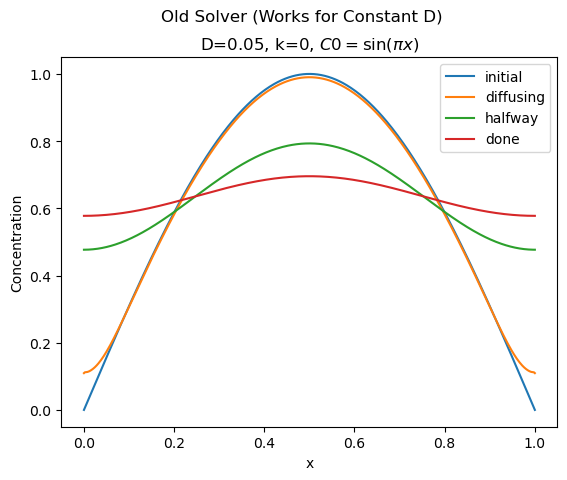

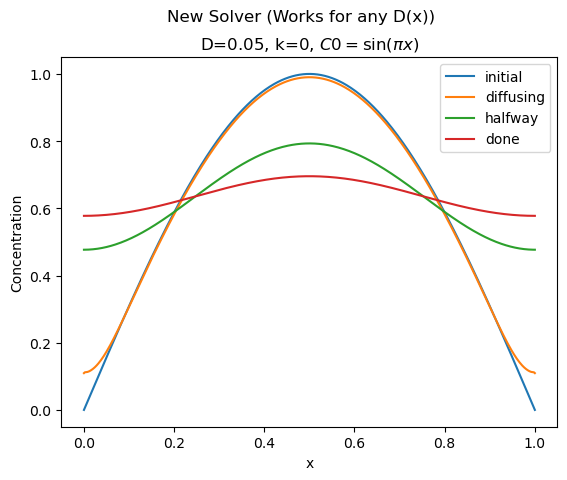

In [ ]:
# Testing with constant D(x) (Neumann BCs)

L = 1.0
params = {
    "C0": lambda x: np.sin(np.pi*x / L),
    "D": 0.05,
    "L": L,
    "k": 0,
    "tf": 1,
    "bounds": 'Neumann'
}


C_old = imex(**params)
params['D'] = lambda x: 0.05
C_new = imex_var(**params)

x = np.linspace(0, L, C_old.shape[1])

solutions = [(C_old, 'Neumann BCs: Old Solver (Works for Constant D)'), 
             (C_new, 'Neumann BCs: New Solver (Works for any D(x))')]

for C, title in solutions:
    plt.plot(x, C[0], label='initial')
    plt.plot(x, C[10], label = 'diffusing')
    plt.plot(x, C[250], label = 'halfway')
    plt.plot(x, C[-1], label='done')
    plt.xlabel('x')
    plt.ylabel('Concentration')
    plt.suptitle(title)
    plt.title(r"D=0.05, k=0, $C0=\sin(\pi x)$")
    plt.legend()
    plt.show()



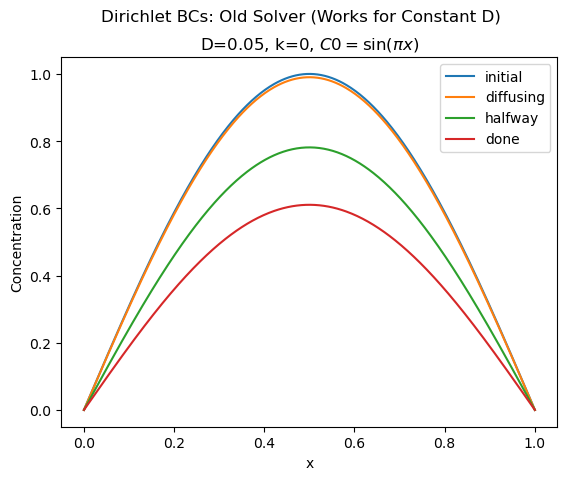

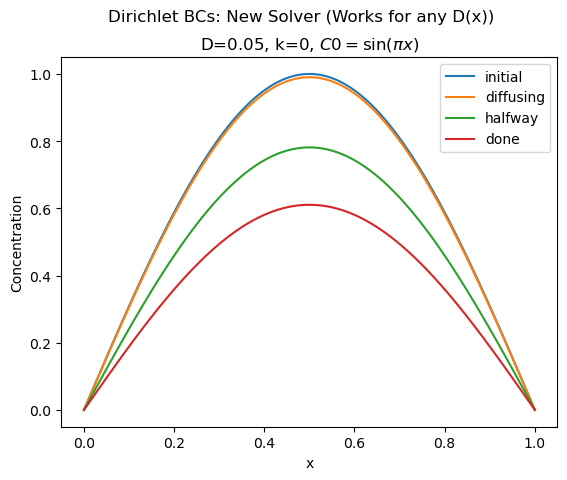

In [13]:
# Testing with constant D(x) (Dirichlet BCs)

L = 1.0
params = {
    "C0": lambda x: np.sin(np.pi*x / L),
    "D": 0.05,
    "L": L,
    "k": 0,
    "tf": 1,
    "bounds": 'Dirichlet'
}


C_old = imex(**params)
params['D'] = lambda x: 0.05
C_new = imex_var(**params)

x = np.linspace(0, L, C_old.shape[1])

solutions = [(C_old, 'Dirichlet BCs: Old Solver (Works for Constant D)'), 
             (C_new, 'Dirichlet BCs: New Solver (Works for any D(x))')]

for C, title in solutions:
    plt.plot(x, C[0], label='initial')
    plt.plot(x, C[10], label = 'diffusing')
    plt.plot(x, C[250], label = 'halfway')
    plt.plot(x, C[-1], label='done')
    plt.xlabel('x')
    plt.ylabel('Concentration')
    plt.suptitle(title)
    plt.title(r"D=0.05, k=0, $C0=\sin(\pi x)$")
    plt.legend()
    plt.show()



### Testing Conservation of Solute

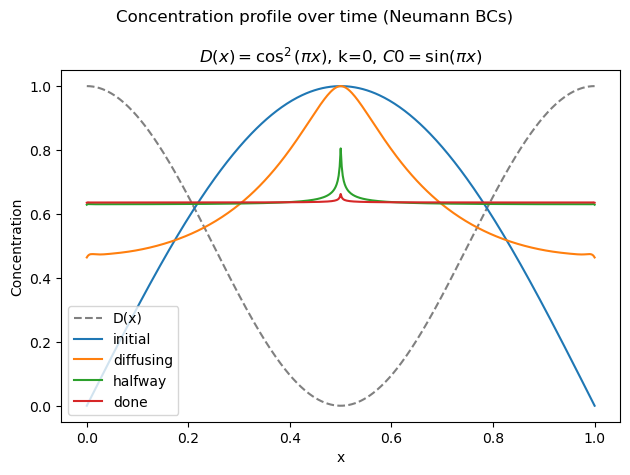

Total Solute:
t=0.00s: 0.6353
t=0.04s: 0.6363
t=0.50s: 0.6366
t=1.00s: 0.6366


In [12]:
# Testing conservation of solute

numeric = imex_var
L = 1.0
params = {
    "C0": lambda x: np.sin(np.pi*x / L),
    "D": lambda x: np.cos(np.pi*x / L)**2,
    "L": L,
    "k": 0,
    "tf": 1,
    "bounds": 'Neumann'
}


C = numeric(**params)

L = params['L']
x = np.linspace(0, L, C.shape[1])
dt = params['tf']/C.shape[0]
dx = L/C.shape[1]

plt.plot(x, params['D'](x), label='D(x)', linestyle='--', color='gray')

plt.plot(x, C[0], label='initial')
plt.plot(x, C[20], label = 'diffusing')
plt.plot(x, C[250], label = 'halfway')
plt.plot(x, C[-1], label='done')
plt.xlabel('x')
plt.ylabel('Concentration')
plt.suptitle(f"Concentration profile over time ({params['bounds']} BCs)")
plt.title(r"$D(x)=\cos^2(\pi x)$, k=0, $C0=\sin(\pi x)$")
plt.legend()
plt.tight_layout()
plt.show()

print("Total Solute:")
print(f't=0.00s: {np.sum(C[0]*dx):.4f}')
print(f't={20*dt:.2f}s: {np.sum(C[20]*dx):.4f}')
print(f't={250*dt:.2f}s: {np.sum(C[250]*dx):.4f}')
print(f't=1.00s: {np.sum(C[-1]*dx):.4f}')

## Testing Accuracy vs. Nx and Nt

### Implementation

In [4]:
def test_accuracy(
        solver: Callable, 
        N_range: tuple, 
        err_func: Callable, 
        params: dict,
        analytic = None,
        ref_factor = 16,
        store_soln_data = False
    ):
    '''
    Tests the accurary of the numerical solution vs a reference solution over a range of Nx and Nt.
    If no analytic solution is available, the reference solution used is the numeric solution with 
    N values a specified multiple higher than the highest tested value.

    solver: the solver being tested
    N_range: (Nx_low, Nx_high, Nt_low, Nt_high). Each N has double the points of the last.
             Rounds N_high up to nearest power of 2 multiple of N_low.
    err_func: how the discrepancy between the numeric and analytic solution is calculated.
    params: Dict containing the params for the solver. Ex:
        params = {
            "C0": C0,
            "D": D,
            "L": L,
            "k": k,
            "tf": tf
        }
    analytic: the analytic solution, if available. Otherwise, equals None.
    ref_factor: Nx_ref = Nx_high*ref_factor, etc.
    '''

    if len(N_range) == 2:
        Nx_low = N_range[0]
        Nx_high = N_range[1]
        Nt_low = N_range[0]
        Nt_high = N_range[1]

    elif len(N_range) == 4:
        Nx_low = N_range[0]
        Nx_high = N_range[1]
        Nt_low = N_range[2]
        Nt_high = N_range[3]
    else: 
        raise ValueError("N_range must be a tuple of length 2 or 4")
    
    Nx_values = []
    Nt_values = []
    for N_low, N_high, N_values in (Nx_low, Nx_high, Nx_values), (Nt_low, Nt_high, Nt_values):
        N = N_low
        while N < N_high:
            N_values.append(N)
            N *= 2
        N_values.append(N)  
    Nx_values = np.array(Nx_values, dtype=int)
    Nt_values = np.array(Nt_values, dtype=int)

    Nx_ref = Nx_values[-1]*ref_factor
    Nt_ref = Nt_values[-1]*ref_factor
    
    if analytic:
        ref_soln = analytic(**params, Nx=Nx_ref)
    else: 
        ref_soln = solver(**params, Nx=Nx_ref, Nt=Nt_ref)[-1]


    soln_data_rows = []
    if store_soln_data: 
        columns = ["Nx", "Nt", "Error", "Numeric Solution", "Sampled Reference Solution"]
    else:
        columns = ["Nx", "Nt", "Error"]


    for Nx in tqdm(Nx_values, desc="Calculating error"):
        for Nt in Nt_values:

            num_soln = solver(**params, Nx=Nx, Nt=Nt)[-1]
            test_points = np.linspace(0, Nx_ref, Nx+1, dtype=int) # subsamples evenly spaced points along the analytic soln for each point on the num soln.
            ref_soln_sampled = ref_soln[test_points]
            if len(ref_soln_sampled) != len(num_soln): raise ValueError("Length of the reference and numeric solutions do not match!")
            err = err_func(ref_soln_sampled, num_soln)                  

            row = [Nx, Nt, err]
            if store_soln_data:
                row.extend([num_soln, ref_soln_sampled])

            soln_data_rows.append(row)
            
    soln_data = pd.DataFrame(soln_data_rows, columns=columns)

    return soln_data


def test_accuracy_simple(
        solver: Callable, 
        N_range: tuple, 
        err_func: Callable, 
        params: dict,
        analytic: Callable,
        store_soln_data = False
    ):
    '''
    Tests the accurary of the numerical solution vs the analytic solution over a range of Nx and Nt.
    Only works when there is an analytic solution available.
    **Does not samle points** -- regenerates the analytic solution for each Nx.

    solver: the solver being tested
    N_range: tuple with the lower and upper N (number of timesteps and spatial steps) being calculated, and what to scale by. 
                Since each term must be a multuple of the last, the last term rounds up to the nearest power of the "scale by" factor.
    err_func: how the discrepancy between the numeric and analytic solution is calculated.
    Params: Dict containing the params for the solver. Ex:
        params = {
            "C0": C0,
            "D": D,
            "L": L,
            "k": k,
            "tf": tf
        }
    '''

    if len(N_range) == 2: 
        Nx_low = N_range[0]
        Nt_low = N_range[0]
        Nx_high = N_range[1]
        Nt_high = N_range[1]
        Nx_countby = 1
        Nt_countby = 1
    elif len(N_range) == 3: 
        Nx_low = N_range[0]
        Nt_low = N_range[0]
        Nx_high = N_range[1]
        Nt_high = N_range[1]
        Nx_countby = N_range[2]
        Nt_countby = N_range[2]
    elif len(N_range) == 6:
        Nx_low = N_range[0]
        Nx_high = N_range[1]
        Nx_countby = N_range[2]
        Nt_low = N_range[3]
        Nt_high = N_range[4]
        Nt_countby = N_range[5]
    else: 
        raise ValueError("N_range must be a tuple of length 2, 3, or 6")

    Nx_values = range(Nx_low, Nx_high, Nx_countby)
    Nt_values = range(Nt_low, Nt_high, Nt_countby)

    soln_data_rows = []

    if store_soln_data: 
        columns = ["Nx", "Nt", "Error", "Numeric Solution", "Analytic Solution"]
    else:
        columns = ["Nx", "Nt", "Error"]


    for Nx in tqdm(Nx_values, desc="Calculating error"):
        for Nt in Nt_values:

            num_soln = solver(**params, Nx=Nx, Nt=Nt)[-1]
            an_soln = analytic(**params, Nx=Nx)
            err = err_func(num_soln, an_soln)                  

            row = [Nx, Nt, err]
            if store_soln_data:
                row.extend([num_soln, an_soln])
            soln_data_rows.append(row)
            
    soln_data = pd.DataFrame(soln_data_rows, columns=columns)

    return soln_data

def L2norm(num_soln, an_soln):
    '''
    Computes the distance between "points" in the solution vector and analytic solution vector.
    This is normalized by the norm of the analytic solution.  
    '''
    err = np.linalg.norm(num_soln - an_soln) / np.linalg.norm(an_soln)
    return err

### Testing Simple Error Calculation (no sampling)

In [ ]:
# Calculating some errors (Neumann BCs)

print('---Figure 1---')

numeric = imex
N_range = (2, 20, 1)
params = {
    "C0": lambda x: 25,
    "D": 0.5,
    "L": 1,
    "k": 0.1, 
    "tf": 1,
    "bounds": 'Neumann'
}
costs_1 = test_accuracy_simple(numeric, N_range, L2norm, params, analytic)


print('---Figure 2---')

N_range = (5, 100, 20, 2, 40, 1) # Nx range, Nt range
L = 1
params = {
    "C0": lambda x: np.sin(np.pi*x / L),
    "D": 20,
    "L": L,
    "k": 0,
    "tf": 1,
    "bounds": 'Neumann'
}
costs_2 = test_accuracy_simple(numeric, N_range, L2norm, params, analytic)


print('---Figure 3---')

N_range = (2, 40, 1, 5, 100, 20) # Nx range, Nt range
L = 1
params = {
    "C0": lambda x: np.sin(np.pi*x / L),
    "D": 20,
    "L": L,
    "k": 0,
    "tf": 1,
    "bounds": 'Neumann'
}
costs_3 = test_accuracy_simple(numeric, N_range, L2norm, params, analytic)

---Figure 1---


Calculating error:   0%|          | 0/18 [00:00<?, ?it/s]

Calculating error: 100%|██████████| 18/18 [00:04<00:00,  4.17it/s]


---Figure 2---


Calculating error: 100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


---Figure 3---


Calculating error: 100%|██████████| 38/38 [00:13<00:00,  2.82it/s]


<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
C:\Users\willi\AppData\Local\Temp\ipykernel_14456\55654215.py:24: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f"{params['bounds']} BCs, $C0= \sin(\pi x / L)$, D={params['D']}, k={params['k']}")
C:\Users\willi\AppData\Local\Temp\ipykernel_14456\55654215.py:46: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f"{params['bounds']} BCs, $C0= \sin(\pi x / L)$, D={params['D']}, k={params['k']}")


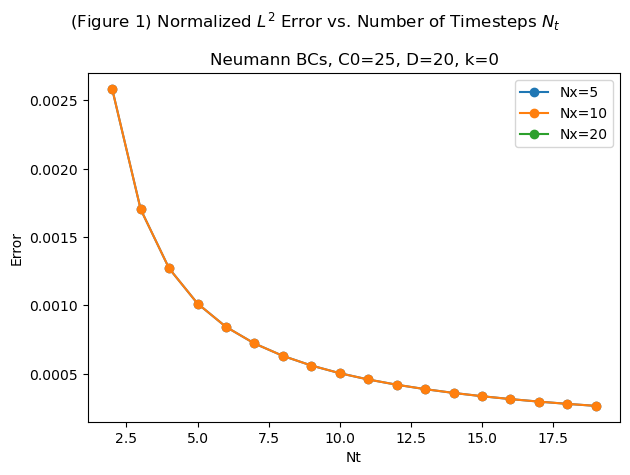

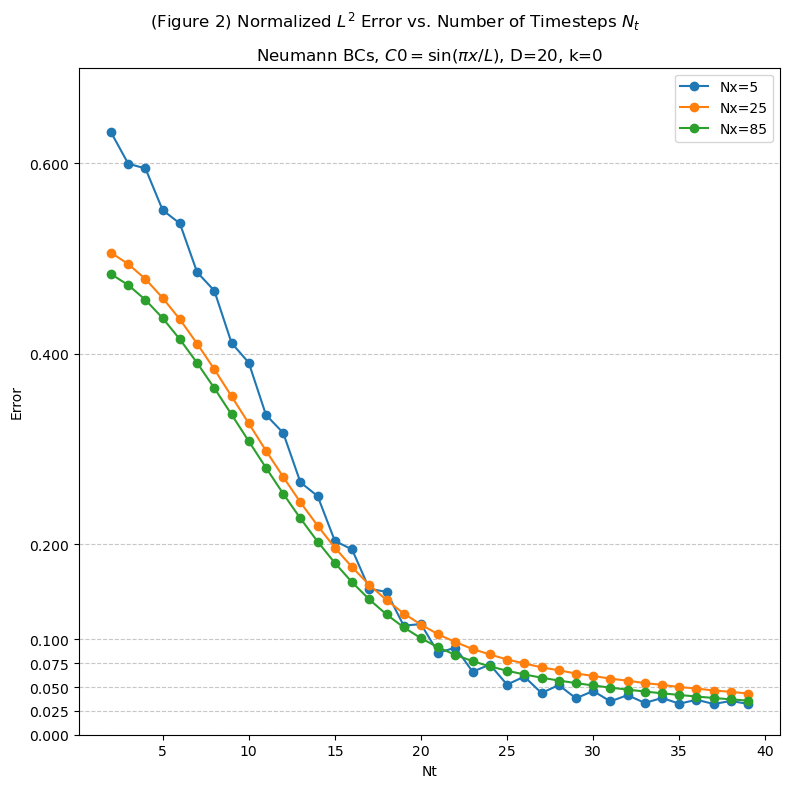

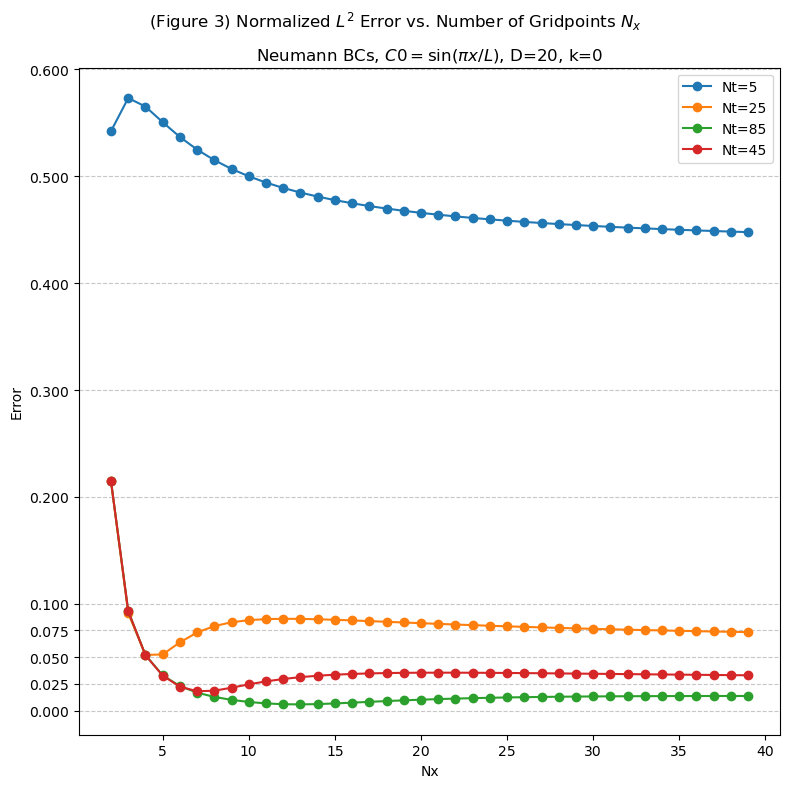

In [14]:
# Plotting the errors (Neumann BCs)

plt.figure(1)

plt.xlabel('Nt')
plt.ylabel('Error')
plt.suptitle('(Figure 1) Normalized $L^2$ Error vs. Number of Timesteps $N_t$')
plt.title(f"{params['bounds']} BCs, C0=25, D={params['D']}, k={params['k']}")

for Nx in [5, 10, 20]:
    sub_costs = costs_1.loc[costs_1["Nx"]==Nx]
    plt.plot(sub_costs["Nt"], sub_costs["Error"], 'o-', label=f'Nx={Nx}')

plt.legend()
plt.tight_layout()



plt.figure(2, figsize=(8,8))

plt.xlabel('Nt')
plt.ylabel('Error')
plt.suptitle('(Figure 2) Normalized $L^2$ Error vs. Number of Timesteps $N_t$')
plt.title(f"{params['bounds']} BCs, $C0= \sin(\pi x / L)$, D={params['D']}, k={params['k']}")

for Nx in [5, 25, 85]:
    sub_costs = costs_2.loc[costs_2["Nx"]==Nx]
    plt.plot(sub_costs["Nt"], sub_costs["Error"], 'o-', label=f'Nx={Nx}')

yticks = np.concatenate([np.linspace(0, 0.1, 5), np.linspace(0.2, 1, 5)])
plt.yticks(yticks)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim(0,0.7)

plt.legend()
plt.tight_layout()



plt.figure(3, figsize=(8,8))

plt.xlabel('Nx')
plt.ylabel('Error')
plt.suptitle('(Figure 3) Normalized $L^2$ Error vs. Number of Gridpoints $N_x$')
plt.title(f"{params['bounds']} BCs, $C0= \sin(\pi x / L)$, D={params['D']}, k={params['k']}")

for Nt in [5, 25, 85, 45]:
    sub_costs = costs_3.loc[costs_3["Nt"]==Nt]
    plt.plot(sub_costs["Nx"], sub_costs["Error"], 'o-', label=f'Nt={Nt}')

yticks = np.concatenate([np.linspace(0, 0.1, 5), np.linspace(0.2, 0.6, 5)])
plt.yticks(yticks)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend()
plt.tight_layout()

### Heat Map plotting Simple Error Calculation vs. Nt, Nx

In [ ]:
# Heat map for Nx, Nt

L = 1.0
params = {
    "C0": lambda x: np.sin(np.pi * x / L),
    "D": 0.5,
    "L": L,
    "k": 0.0,
    "tf": 1.0,
    "bounds": "Neumann",
}
N_range = (2, 60, 1, 2, 60, 1)
costs_heatmap = test_accuracy_simple(imex, N_range, L2norm, params, analytic)

Calculating error: 100%|██████████| 58/58 [02:22<00:00,  2.46s/it]


In [39]:
costs_heatmap.to_csv('./data/costs_heatmap.csv')

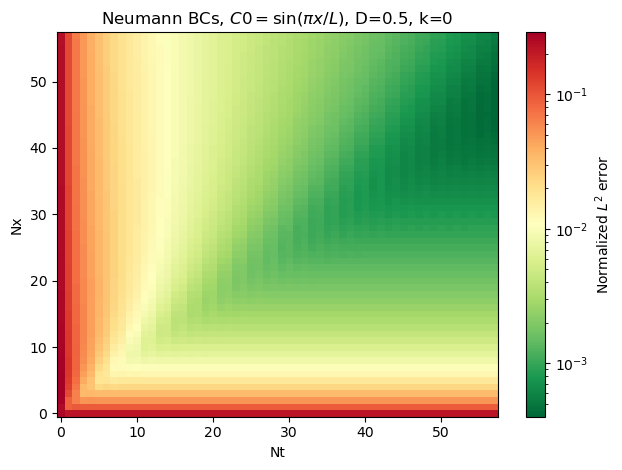

In [40]:
from matplotlib.colors import LogNorm

costs_heatmap = pd.read_csv('./data/costs_heatmap.csv')
costs_map = costs_heatmap.pivot(index="Nx", columns="Nt", values="Error")

vmin = costs_map.values.min()
vmax = costs_map.values.max()

plt.imshow(costs_map.values, aspect='auto', origin='lower', cmap='RdYlGn_r', norm=LogNorm(vmin, vmax))

plt.colorbar(label="Normalized $L^2$ error")
plt.xlabel("Nt")
plt.ylabel("Nx")
plt.title(r"Neumann BCs, $C0 = \sin(\pi x / L)$, D=0.5, k=0")


plt.tight_layout()
plt.show()

### Testing Error Calculation Using Sampled Reference Points

In [23]:
print('---Simple Error Calculation---')

numeric = imex
N_range = (5, 100, 20, 2, 40, 1) # Nx range, Nt range
L = 1
params = {
    "C0": lambda x: np.sin(np.pi*x / L),
    "D": 20,
    "L": L,
    "k": 0,
    "tf": 1,
    "bounds": 'Neumann'
}
costs_1 = test_accuracy_simple(numeric, N_range, L2norm, params, analytic)

print('---Error Calculation---')

N_range = (5, 100, 2, 40) # Nx range, Nt range (Scales by 2)

costs_2 = test_accuracy(numeric, N_range, L2norm, params, analytic)

---Simple Error Calculation---


Calculating error: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


---Error Calculation---


Calculating error: 100%|██████████| 6/6 [00:00<00:00, 161.00it/s]


In [16]:
costs_1

,Nx,Nt,Error
0,5,2,0.632217
1,5,3,0.599288
2,5,4,0.594270
3,5,5,0.550584
4,5,6,0.536530
...,...,...,...
185,85,35,0.041727
186,85,36,0.040102
187,85,37,0.038552
188,85,38,0.037119


In [17]:
costs_2

,Nx,Nt,Error
0,5,2,0.626764
1,5,4,0.597550
2,5,8,0.487196
3,5,16,0.208162
4,5,32,0.043135
5,5,64,0.034256
6,10,2,0.525008
7,10,4,0.502105
8,10,8,0.417403
9,10,16,0.203506


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\willi\AppData\Local\Temp\ipykernel_14456\1856249872.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f"{params['bounds']} BCs, $C0= \sin(\pi x / L)$, D={params['D']}, k={params['k']}")
C:\Users\willi\AppData\Local\Temp\ipykernel_14456\1856249872.py:28: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f"{params['bounds']} BCs, $C0= \sin(\pi x / L)$, D={params['D']}, k={params['k']}")


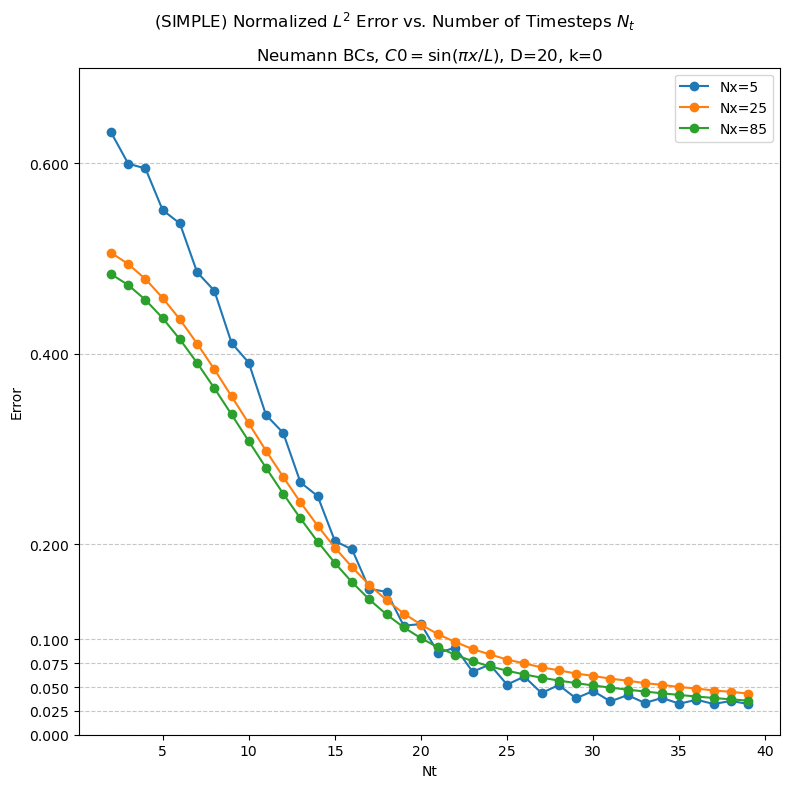

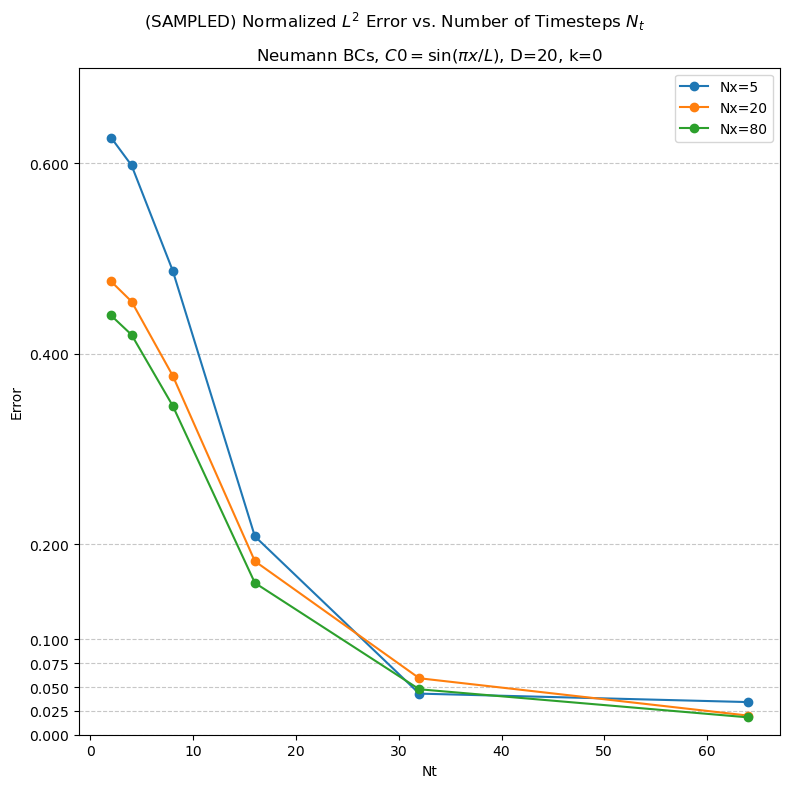

In [20]:
plt.figure(1, figsize=(8,8))

plt.xlabel('Nt')
plt.ylabel('Error')
plt.suptitle('(SIMPLE) Normalized $L^2$ Error vs. Number of Timesteps $N_t$')
plt.title(f"{params['bounds']} BCs, $C0= \sin(\pi x / L)$, D={params['D']}, k={params['k']}")

for Nx in [5, 25, 85]:
    sub_costs = costs_1.loc[costs_1["Nx"]==Nx]
    plt.plot(sub_costs["Nt"], sub_costs["Error"], 'o-', label=f'Nx={Nx}')

yticks = np.concatenate([np.linspace(0, 0.1, 5), np.linspace(0.2, 1, 5)])
plt.yticks(yticks)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim(0,0.7)

plt.legend()
plt.tight_layout()

# ---------------

plt.figure(2, figsize=(8,8))

plt.xlabel('Nt')
plt.ylabel('Error')
plt.suptitle('(SAMPLED) Normalized $L^2$ Error vs. Number of Timesteps $N_t$')
plt.title(f"{params['bounds']} BCs, $C0= \sin(\pi x / L)$, D={params['D']}, k={params['k']}")

for Nx in [5, 20, 80]:
    sub_costs = costs_2.loc[costs_2["Nx"]==Nx]
    plt.plot(sub_costs["Nt"], sub_costs["Error"], 'o-', label=f'Nx={Nx}')

yticks = np.concatenate([np.linspace(0, 0.1, 5), np.linspace(0.2, 1, 5)])
plt.yticks(yticks)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim(0,0.7)

plt.legend()
plt.tight_layout()

### Error Calculation for Variable D(x) (No Analytic Soln)

In [5]:
print('---Variable Diffusion Error Calculation---')

print('--Constant Nx')
numeric = imex_var
L = 1
params = {
    "C0": lambda x: np.sin(np.pi*x / L),
    "D": lambda x: np.cos(np.pi*x / L)**2,
    "L": L,
    "k": 0,
    "tf": 1,
    "bounds": 'Neumann'
}

N_range = (5, 100, 2, 40) # Nx range, Nt range (Scales by 2)

costs_1 = test_accuracy(numeric, N_range, L2norm, params)

print('--Constant Nt--')

N_range = (2, 40, 5, 100) # Nx range, Nt range

costs_2 = test_accuracy(numeric, N_range, L2norm, params)

---Variable Diffusion Error Calculation---
--Constant Nx


Calculating error: 100%|██████████| 6/6 [00:00<00:00, 199.82it/s]


--Constant Nt--


Calculating error: 100%|██████████| 6/6 [00:00<00:00, 148.09it/s]


In [30]:
costs_2

,Nx,Nt,Error
0,2,5,0.300437
1,2,10,0.300498
2,2,20,0.300527
3,2,40,0.300535
4,2,80,0.300537
5,2,160,0.300537
6,4,5,0.070419
7,4,10,0.071682
8,4,20,0.071680
9,4,40,0.071679


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
C:\Users\willi\AppData\Local\Temp\ipykernel_14456\3905848224.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f"{params['bounds']} BCs, $C0= \sin(\pi x / L)$, $D=\cos^2(\pi x / L)$, k={params['k']}")
C:\Users\willi\AppData\Local\Temp\ipykernel_14456\3905848224.py:27: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f"{params['bounds']} BCs, $C0= \sin(\pi x / L)$, $D=\cos^2(\pi x / L)$, k={params['k']}")


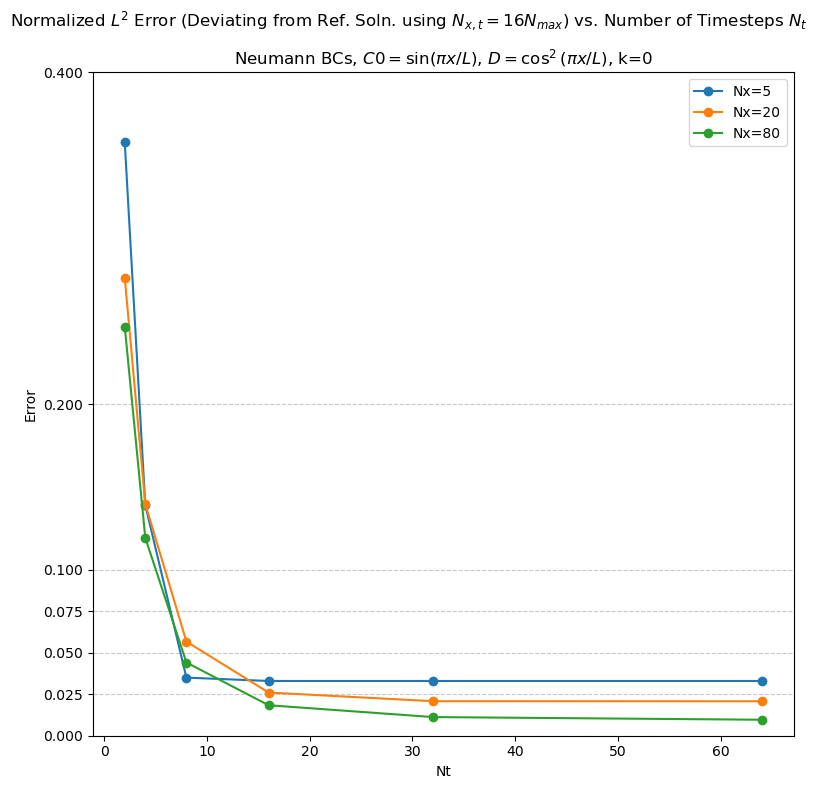

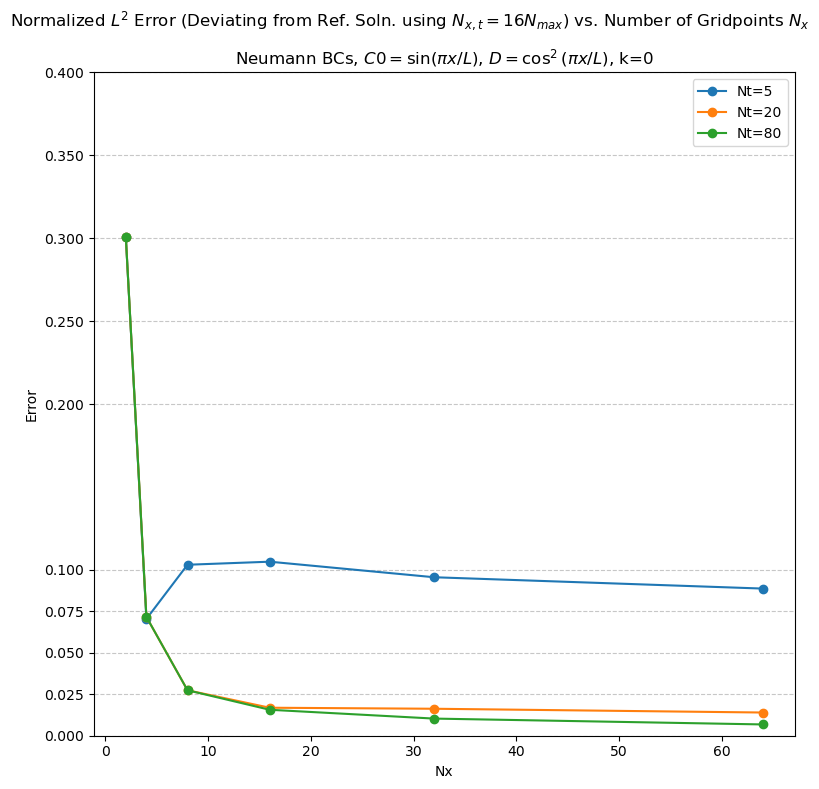

In [33]:
plt.figure(1, figsize=(8,8))

plt.xlabel('Nt')
plt.ylabel('Error')
plt.suptitle('Normalized $L^2$ Error (Deviating from Ref. Soln. using $N_{x,t}=16 N_{max}$) vs. Number of Timesteps $N_t$')
plt.title(f"{params['bounds']} BCs, $C0= \sin(\pi x / L)$, $D=\cos^2(\pi x / L)$, k={params['k']}")

for Nx in [5, 20, 80]:
    sub_costs = costs_1.loc[costs_1["Nx"]==Nx]
    plt.plot(sub_costs["Nt"], sub_costs["Error"], 'o-', label=f'Nx={Nx}')

yticks = np.concatenate([np.linspace(0, 0.1, 5), np.linspace(0.2, 1, 5)])
plt.yticks(yticks)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim(0,0.4)

plt.legend()
plt.tight_layout()


plt.figure(2, figsize=(8,8))

plt.xlabel('Nx')
plt.ylabel('Error')
plt.suptitle('Normalized $L^2$ Error (Deviating from Ref. Soln. using $N_{x,t}=16 N_{max}$) vs. Number of Gridpoints $N_x$')
plt.title(f"{params['bounds']} BCs, $C0= \sin(\pi x / L)$, $D=\cos^2(\pi x / L)$, k={params['k']}")

for Nt in [5, 20, 80]:
    sub_costs = costs_2.loc[costs_2["Nt"]==Nt]
    plt.plot(sub_costs["Nx"], sub_costs["Error"], 'o-', label=f'Nt={Nt}')

yticks = np.concatenate([np.linspace(0, 0.1, 5), np.linspace(0.2, 0.4, 5)])
plt.yticks(yticks)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim(0,0.4)

plt.legend()
plt.tight_layout()

## Choosing Nx, Nt based on Error Calculation

### Implementation

In [24]:
def choose_optimal(err_data, max_err):
    '''
    Given error data for Nx, Nt, chooses the optimal combination. a
    Assumes computational cost = Nx*Nt.

    err_data: pd dataframe with columns Nx, Nt, Error
    max_err: The maximum acceptable L2 error from analytic/reference solution
    '''

    err_data_acceptable = err_data[err_data["Error"] <= max_err]

    
    if err_data_acceptable.empty: raise ValueError(f"No (Nx, Nt) combination satisfies the error tolerance (err = {max_err}).")

    err_data_acceptable["Cost"] = err_data_acceptable["Nx"]*err_data_acceptable["Nt"]

    optimal = err_data_acceptable.sort_values(by=["Cost", "Error"]).iloc[0] # Locate cheapest solution (best Nx, Nt combo) then minimize error

    return optimal

In [25]:
optimal = choose_optimal(costs_2, 0.01)

optimal

C:\Users\willi\AppData\Local\Temp\ipykernel_22620\801754433.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  err_data_acceptable["Cost"] = err_data_acceptable["Nx"]*err_data_acceptable["Nt"]


Nx         64.000000
Nt         40.000000
Error       0.008071
Cost     2560.000000
Name: 33, dtype: float64

In [26]:
rows = []
cols = ["Nx", "Nt", "Error", "Cost"]
for err in np.linspace(0.01, 1, 100):
    optimal = choose_optimal(costs_2, err)
    rows.append([optimal["Nx"], optimal["Nt"], optimal["Error"], optimal["Cost"]])

err_data = pd.DataFrame(rows, columns=cols)

err_data

C:\Users\willi\AppData\Local\Temp\ipykernel_22620\801754433.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  err_data_acceptable["Cost"] = err_data_acceptable["Nx"]*err_data_acceptable["Nt"]
C:\Users\willi\AppData\Local\Temp\ipykernel_22620\801754433.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  err_data_acceptable["Cost"] = err_data_acceptable["Nx"]*err_data_acceptable["Nt"]
C:\Users\willi\AppData\Local\Temp\ipykernel_22620\801754433.py:15: SettingWithCopyWarning: 
A value is trying to be set on

,Nx,Nt,Error,Cost
0,64.0,40.0,0.008071,2560.0
1,16.0,20.0,0.016878,320.0
2,8.0,20.0,0.027410,160.0
3,8.0,10.0,0.033327,80.0
4,8.0,10.0,0.033327,80.0
...,...,...,...,...
95,2.0,5.0,0.300437,10.0
96,2.0,5.0,0.300437,10.0
97,2.0,5.0,0.300437,10.0
98,2.0,5.0,0.300437,10.0


<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\willi\AppData\Local\Temp\ipykernel_22620\2580877860.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f"C-N Solution. BCs: Neumann; ICs: $C0= \sin(\pi x / L)$, $D=\cos^2(\pi x / L)$, k=0")


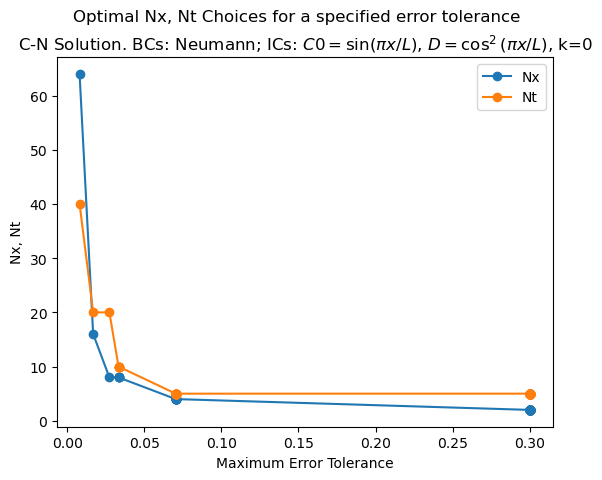

In [32]:
plt.plot(err_data["Error"], err_data["Nx"], 'o-', label='Nx')
plt.plot(err_data["Error"], err_data["Nt"], 'o-', label='Nt')
plt.suptitle('Optimal Nx, Nt Choices for a specified error tolerance')
plt.title(f"C-N Solution. BCs: Neumann; ICs: $C0= \sin(\pi x / L)$, $D=\cos^2(\pi x / L)$, k=0")
plt.ylabel("Nx, Nt")
plt.xlabel("Maximum Error Tolerance")
plt.legend()

## Coupled Species with Boundary Influx

This system of equations takes the form: 

$$
\begin{align}
A \bold{C_A}^{n+1} &= B \bold{C_A}^n - \Delta t k \bold{C_A}^n \odot \bold{C_B}^n
\\[1em]
A \bold{C_B}^{n+1} &= B \bold{C_B}^n - \Delta t k \bold{C_A}^n \odot \bold{C_B}^n
\end{align}
$$

Here I'm using $\bold{C_A}$ To denote species A and $\bold{C_B}$ to denote species B because I'm already using $A$ and $B$ for the LHS and RHS matrices defined previously. $\odot$ is denoting component multiplication.

Because of the $\frac{\partial C_A}{\partial x} (L,t)=0$ boundary condition, $\frac{\partial^2 C_A}{\partial x^2}=0$ so the concentration of B cannot change at this end.


In [ ]:
def CN3(CA0: Callable, CB0: Callable, CB_surf, DA, DB, L, k, tf, nspace=500, ntime=500):
    '''
    Uses CN propgation to find concentration profile of both species A and B over time. 
    Uses boundary condition C(0,0)=C(0,L); B(0,t)=B_surf, db/dx|(L,t)=0

    CA0: Function that represents the concentration profile at t=0.
    CB0: Same for CB
    CB_surf: CB fixed value at boundary x=0
    D: diffusion coefficient 
    L: length of rod
    tf: final time
    nspace: number of spatial steps
    ntime: number of timesteps
    '''
    dx = L/(nspace-1)
    dt = tf/(ntime-1)
    rA = (DA*dt)/(2*dx**2)
    rB = (DB*dt)/(2*dx**2)

    A_bands_A = np.zeros((3,nspace))
    A_bands_A[0,1:] = -rA
    A_bands_A[1,:] = 1+2*rA
    A_bands_A[2,:-1] = -rA

    A_bands_B = np.zeros((3,nspace))
    A_bands_B[0,1:] = -rB
    A_bands_B[1,:] = 1+2*rB
    A_bands_B[2,:-1] = -rB
    """ # Neumann boundary
    A_bands_B[0,-1] = 0      # upper diag
    A_bands_B[1,-1] = 1      # main diag
    A_bands_B[2,-2] = -1     # lower diag """



    B_A = np.diag((1-2*rA) * np.ones(nspace)) + np.diag(rA*np.ones(nspace-1), k=+1)+np.diag(rA*np.ones(nspace-1), k=-1)
    B_B = np.diag((1-2*rB) * np.ones(nspace)) + np.diag(rB*np.ones(nspace-1), k=+1)+np.diag(rB*np.ones(nspace-1), k=-1)

    CA = np.zeros((ntime+1, nspace)) # (n,i)
    CB = np.zeros((ntime+1, nspace))

    CA[0,:] = CA0(np.linspace(0, L, nspace))
    CB[0,:] = CB0(np.linspace(0, L, nspace))
    # Boundaries
    CA[0,0]=0
    CA[0,-1]=0
    CB[0,0]=CB_surf

    for n in range(ntime):
        # Initialize RHS
        RHS_A = B_A@CA[n] - dt*k*CA[n]*CB[n]
        RHS_B = B_B@CB[n] - dt*k*CA[n]*CB[n]
        # Solve
        CA[n+1,:]=la.solve_banded((1,1), A_bands_A, RHS_A)
        CB[n+1,:]=la.solve_banded((1,1), A_bands_B, RHS_B) # (1,1) denotes A has 1 diagonal row above main diag, 1 below.
        # Enforce Dirichlet
        CA[n+1,0]  = 0
        CA[n+1,-1] = 0
        CB[n+1,0]  = CB_surf

    return CA, CB


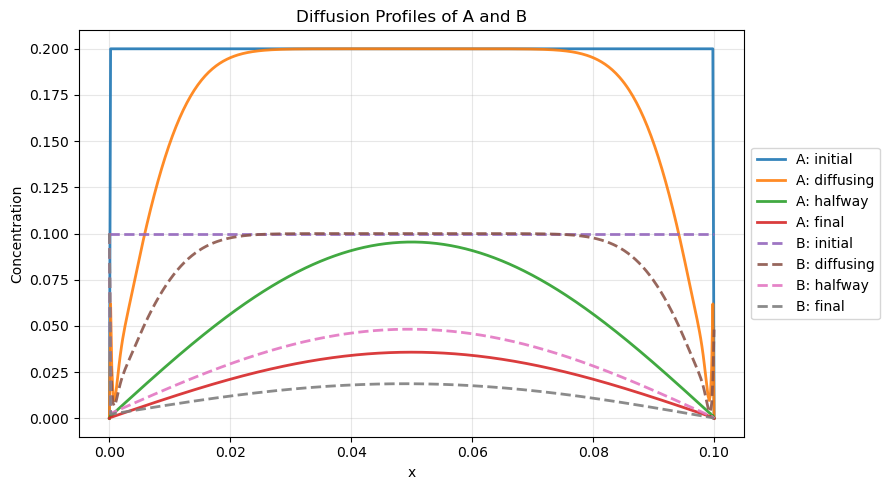

In [ ]:
CA0 = lambda x: 0.2
CB0 = lambda x: 0.1
CB_surf = 0.1
DA = 0.2
DB = 0.2
L = 0.1
k = 1
tf = 0.01

CA, CB = CN3(CA0, CB0, CB_surf, DA, DB, L, k, tf)

x = np.linspace(0, L, CA.shape[1])


# plotting code source: ChatGPT
plt.figure(figsize=(9,5))

line_kwargs_A = dict(linewidth=2, alpha=0.9)
line_kwargs_B = dict(linewidth=2, alpha=0.9, linestyle='--')

plt.plot(x, CA[0],  label='A: initial',   **line_kwargs_A)
plt.plot(x, CA[10], label='A: diffusing', **line_kwargs_A)
plt.plot(x, CA[250],label='A: halfway',   **line_kwargs_A)
plt.plot(x, CA[-1], label='A: final',     **line_kwargs_A)

plt.plot(x, CB[0],  label='B: initial',   **line_kwargs_B)
plt.plot(x, CB[10], label='B: diffusing', **line_kwargs_B)
plt.plot(x, CB[250],label='B: halfway',   **line_kwargs_B)
plt.plot(x, CB[-1], label='B: final',     **line_kwargs_B)

plt.xlabel('x')
plt.ylabel('Concentration')
plt.title('Diffusion Profiles of A and B')
plt.grid(alpha=0.3)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()



In [ ]:
# Verify Boundary
CB[:,0]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.

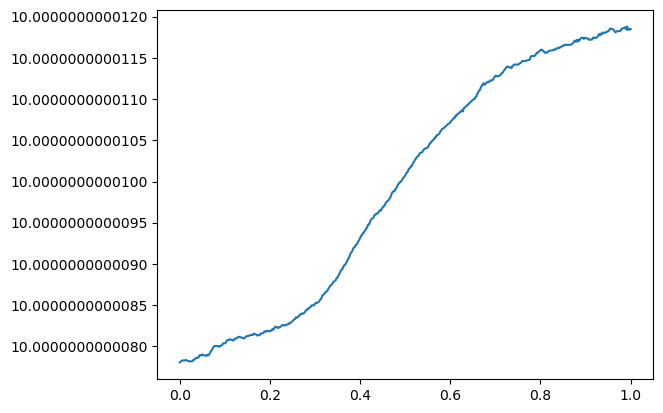

In [ ]:
C0 = lambda x: 10
D = 0.5
L = 1
k = 0.0
tf = 1


C = imex(C0, D, L, k, tf, bounds='Neumann')[-1]

x = np.linspace(0, L, len(C))

plt.plot(x, C, label='imex')
plt.ticklabel_format(useOffset=False, style='plain')

In [ ]:
1-np.array([1,2,3,4,5])

array([ 0, -1, -2, -3, -4])

In [ ]:
r = 2
Nx = 20


B_bands = np.zeros((3,Nx+1))
B_bands[0,1:] = r
B_bands[1,:] = 1-2*r
B_bands[2,:-1] = r
B1 = np.diag(B_bands[1]) + np.diag(B_bands[0,1:], k=+1)+np.diag(B_bands[2,:-1], k=-1)
B2 = np.diag((1-2*r) * np.ones(Nx+1)) + np.diag(r*np.ones(Nx), k=+1)+np.diag(r*np.ones(Nx), k=-1)

B1 == B2

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True

array([ 0,  2,  5,  7, 10])

In [6]:
my_df = pd.DataFrame({
    "Col1": [1, 2, 3, 4, 5],
    "Col2": [3, 5, 1, 6, 4]
})

my_df

,Col1,Col2
0,1,3
1,2,5
2,3,1
3,4,6
4,5,4


In [9]:
sorted = my_df.sort_values(by=["Col1", "Col2"])

sorted

,Col1,Col2
0,1,3
1,2,5
2,3,1
3,4,6
4,5,4
